# Análisis de Componentes Principales (PCA)

En este cuaderno realizaremos un **Análisis de Componentes Principales (PCA)** sobre el dataset `movies.csv`.

**Objetivos**:
- Seleccionar variables numéricas relevantes.
- Verificar las condiciones previas (matriz de correlación, pruebas de KMO y Bartlett).
- Calcular el PCA y revisar la varianza explicada.
- Interpretar los componentes principales.
- Discutir cuántos componentes retener y para qué podrían utilizarse.

In [5]:

# IMPORTAR LIBRERÍAS Y CARGAR DATOS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# (Opcional) Para KMO y Bartlett:
# !pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Configuración estética
sns.set(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (10, 6)

# Cargar dataset
df = pd.read_csv("movies.csv", encoding="latin1")

# Visión general de los datos
df.head()

,id,budget,genres,homePage,productionCompany,productionCompanyCountry,productionCountry,revenue,runtime,video,...,popularity,releaseDate,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount,castWomenAmount,castMenAmount
0,5,4000000,Crime|Comedy,https://www.miramax.com/movie/four-rooms/,Miramax|A Band Apart,US|US,United States of America,4257354.0,98,False,...,20.880,1995-12-09,5.7,2077,2,2,1,25,15,9
1,6,21000000,Action|Thriller|Crime,NaN,Universal Pictures|Largo Entertainment|JVC,US|US|JP,Japan|United States of America,12136938.0,110,False,...,9.596,1993-10-15,6.5,223,3,3,2,15,3,9
2,11,11000000,Adventure|Action|Science Fiction,http://www.starwars.com/films/star-wars-episod...,Lucasfilm|20th Century Fox,US|US,United States of America,775398007.0,121,NaN,...,100.003,1977-05-25,8.2,16598,3,2,1,105,5,62
3,12,94000000,Animation|Family,http://movies.disney.com/finding-nemo,Pixar,US,United States of America,940335536.0,100,NaN,...,134.435,2003-05-30,7.8,15928,2,1,1,24,5,18
4,13,55000000,Comedy|Drama|Romance,NaN,Paramount|The Steve Tisch Company,US|,United States of America,677387716.0,142,False,...,58.751,1994-07-06,8.5,22045,3,2,1,76,18,48


## Selección de Variables y Preprocesamiento

1. **Selección de columnas numéricas**: Solo aquellas útiles para PCA.  
2. **Conversión de datos a numérico**: Para evitar errores al escalar.  
3. **Manejo de datos faltantes**: Eliminamos (o imputamos) según el caso.  
4. **Estandarización**: Se aplica `StandardScaler` para normalizar (media=0, var=1).

---

In [13]:
# SELECCIÓN Y PREPROCESAMIENTO DE VARIABLES

# Ajusta esta lista según las columnas numéricas de tu dataset
cols_numeric = [
    'budget',
    'revenue',
    'popularity',
    'runtime',
    'voteCount',
    'voteAvg',
    'actorsPopularity',
    'actorsAmount',
    'castWomenAmount',
    'castMenAmount'
]

# Crear un DataFrame con solo esas columnas
df_pca = df[cols_numeric].copy()

# Convertir a numérico forzando la conversión, reemplazando con NaN lo que no se pueda convertir
for col in cols_numeric:
    df_pca[col] = pd.to_numeric(df_pca[col], errors='coerce')

# Ver cuántos valores nulos resultan
print("Valores nulos por columna después de to_numeric:\n", df_pca.isnull().sum())

# Eliminar filas con nulos (o imputar, si prefieres)
df_pca.dropna(axis=0, inplace=True)

# Escalado de datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Pasar a DataFrame para revisar
df_scaled = pd.DataFrame(df_scaled, columns=cols_numeric)
df_scaled.head()

Valores nulos por columna después de to_numeric:
 budget                 0
revenue                0
popularity             0
runtime                0
voteCount              0
voteAvg                0
actorsPopularity    9952
actorsAmount           0
castWomenAmount       37
castMenAmount        162
dtype: int64


,budget,revenue,popularity,runtime,voteCount,voteAvg,actorsPopularity,actorsAmount,castWomenAmount,castMenAmount
0,-0.175515,-0.162621,-0.481159,-0.601988,3.434166,0.557957,2.624196,0.426401,1.414214,-0.411314
1,-0.175515,-0.162621,-0.151433,-0.079491,0.173006,-0.591978,-0.252338,0.426401,-0.707107,-0.411310
2,-0.175515,-0.162621,0.488561,0.599755,0.410408,0.027217,-0.515795,0.426401,-0.707107,-0.411310
3,-0.175515,-0.162621,-0.536668,-0.671654,1.872308,-0.238152,0.194909,0.426401,-0.707107,-0.411310
4,-0.175515,-0.162621,-0.356378,-0.323323,-0.901553,0.734870,-0.633547,0.426401,-0.707107,-0.411314


## Verificación de Condiciones Previas para PCA

- **Matriz de Correlación**: Confirma si las variables tienen correlación.  
- **Prueba de Esfericidad de Bartlett**: Si el p-value < 0.05, se asume que la matriz de correlación no es la identidad, y es válido aplicar PCA.  
- **Índice KMO (Kaiser-Meyer-Olkin)**:
  - 0.80 ~ 1.0: Muy bueno  
  - 0.70 ~ 0.79: Medio  
  - 0.60 ~ 0.69: Regular  
  - < 0.60 : PCA/Análisis factorial quizá no sea muy adecuado

---

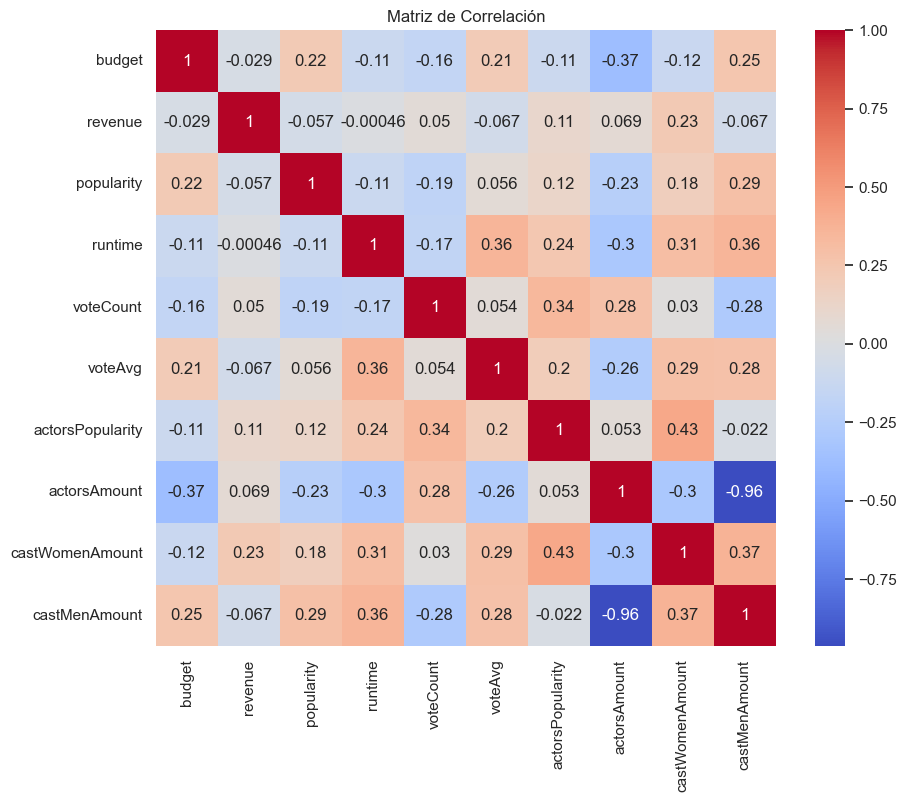

Chi-cuadrado de Bartlett: 164.75377653976344
p-valor de Bartlett: 1.4650216570279115e-15
Prueba de Bartlett: p < 0.05, es adecuado continuar con PCA.
Índice KMO (global): 0.5086403858638644
KMO indica que quizá el PCA no sea muy adecuado.


In [15]:
# MATRIZ DE CORRELACIÓN, PRUEBAS DE BARTLETT Y KMO

# Matriz de correlación
corr_matrix = df_scaled.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

# Prueba de Esfericidad de Bartlett
chi_square_value, p_value = calculate_bartlett_sphericity(df_scaled)
print("Chi-cuadrado de Bartlett:", chi_square_value)
print("p-valor de Bartlett:", p_value)
if p_value < 0.05:
    print("Prueba de Bartlett: p < 0.05, es adecuado continuar con PCA.")
else:
    print("Prueba de Bartlett: p >= 0.05, puede no ser adecuado PCA.")

# Índice KMO
kmo_all, kmo_model = calculate_kmo(df_scaled)
print("Índice KMO (global):", kmo_model)
if kmo_model >= 0.80:
    print("KMO indica una muy buena adecuación.")
elif kmo_model >= 0.70:
    print("KMO indica una adecuación media.")
elif kmo_model >= 0.60:
    print("KMO indica una adecuación regular.")
else:
    print("KMO indica que quizá el PCA no sea muy adecuado.")

## Cálculo del PCA

Aquí ajustamos el modelo PCA con todas las variables seleccionadas y analizamos la **varianza explicada** por cada componente.

---

In [9]:
# CÁLCULO DEL PCA Y VARIANZA EXPLICADA

pca = PCA(n_components=len(cols_numeric))
pca.fit(df_scaled)

# Transformar los datos
pca_data = pca.transform(df_scaled)

# Varianza explicada por componente
var_exp = pca.explained_variance_ratio_
var_exp_acum = np.cumsum(var_exp)

print("Varianza explicada por cada componente:")
for i, valor in enumerate(var_exp):
    print(f"Componente {i+1}: {valor:.4f} (acumulada: {var_exp_acum[i]:.4f})")

Varianza explicada por cada componente:
Componente 1: 0.2843 (acumulada: 0.2843)
Componente 2: 0.1871 (acumulada: 0.4714)
Componente 3: 0.1188 (acumulada: 0.5902)
Componente 4: 0.1087 (acumulada: 0.6989)
Componente 5: 0.0931 (acumulada: 0.7920)
Componente 6: 0.0763 (acumulada: 0.8683)
Componente 7: 0.0562 (acumulada: 0.9245)
Componente 8: 0.0435 (acumulada: 0.9681)
Componente 9: 0.0298 (acumulada: 0.9978)
Componente 10: 0.0022 (acumulada: 1.0000)


## Cálculo del PCA y Varianza Explicada

- Se definen tantos componentes como variables tengamos, para ver la varianza total.  
- Observamos la **proporción de varianza** explicada y la varianza acumulada.  
- Decidimos cuántos componentes retener (por ejemplo, los que sumen ~70-80% de varianza).

---


Varianza explicada por cada componente:
Componente 1: 0.2843 (acumulada: 0.2843)
Componente 2: 0.1871 (acumulada: 0.4714)
Componente 3: 0.1188 (acumulada: 0.5902)
Componente 4: 0.1087 (acumulada: 0.6989)
Componente 5: 0.0931 (acumulada: 0.7920)
Componente 6: 0.0763 (acumulada: 0.8683)
Componente 7: 0.0562 (acumulada: 0.9245)
Componente 8: 0.0435 (acumulada: 0.9681)
Componente 9: 0.0298 (acumulada: 0.9978)
Componente 10: 0.0022 (acumulada: 1.0000)


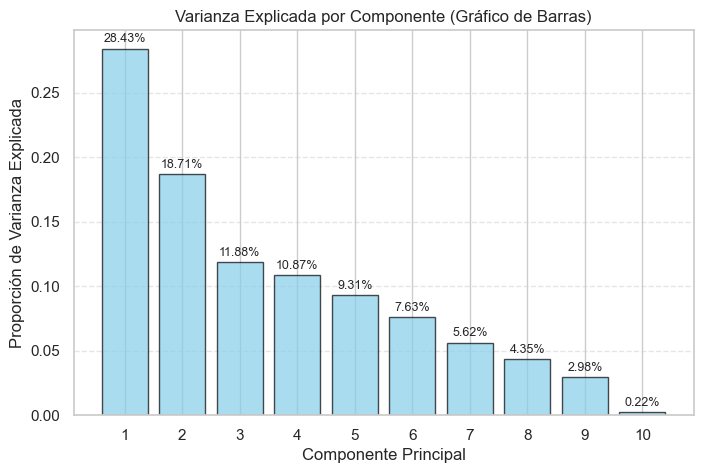

In [17]:
# PCA Y VARIANZA EXPLICADA

# Ajustar PCA con la cantidad de columnas numéricas
pca = PCA(n_components=len(cols_numeric))
pca.fit(df_scaled)

# Transformar los datos
pca_data = pca.transform(df_scaled)

# Varianza explicada por cada componente
var_exp = pca.explained_variance_ratio_
var_exp_acum = np.cumsum(var_exp)

print("\nVarianza explicada por cada componente:")
for i, valor in enumerate(var_exp):
    print(f"Componente {i+1}: {valor:.4f} (acumulada: {var_exp_acum[i]:.4f})")

# -------------------------------
# GRÁFICO DE BARRAS DE VARIANZA EXPLICADA
# -------------------------------
import matplotlib.pyplot as plt
import numpy as np

n_components = len(var_exp)
x_vals = np.arange(1, n_components + 1)

plt.figure(figsize=(8, 5))
plt.bar(x_vals, var_exp, color='skyblue', alpha=0.7, edgecolor='black')

# Anotar el porcentaje de varianza sobre cada barra (opcional)
for i, v in enumerate(var_exp):
    plt.text(i + 1, v + 0.005, f"{v*100:.2f}%", ha='center', fontsize=9)

plt.xlabel("Componente Principal")
plt.ylabel("Proporción de Varianza Explicada")
plt.title("Varianza Explicada por Componente (Gráfico de Barras)")
plt.xticks(x_vals)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Scree Plot (Gráfico de Codo)

Este gráfico muestra la varianza acumulada frente al número de componentes.  
Se suele retener un número de componentes donde la curva se aplana o hasta alcanzar un umbral (70-80% de varianza).

---

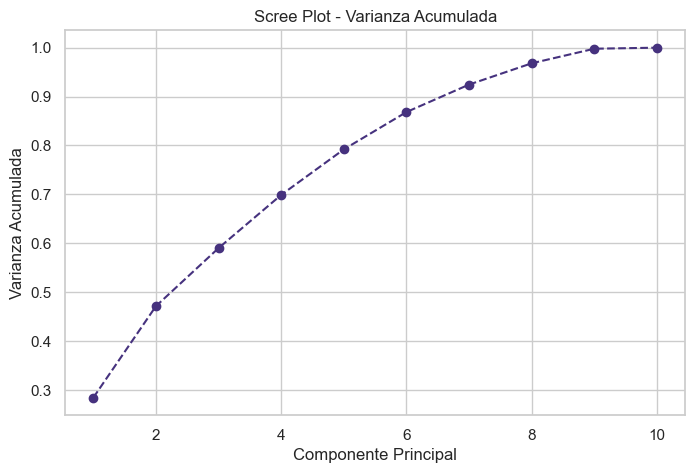

In [18]:
# SCREE PLOT

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cols_numeric)+1), var_exp_acum, marker='o', linestyle='--')
plt.title("Scree Plot - Varianza Acumulada")
plt.xlabel("Componente Principal")
plt.ylabel("Varianza Acumulada")
plt.grid(True)
plt.show()

## Interpretación de los Componentes (Loadings)

Se revisan las cargas (loadings) para cada variable en cada componente.  
- Valores positivos altos: variable contribuye mucho, en sentido positivo.  
- Valores negativos altos (en magnitud): contribuye en sentido inverso.  

---

In [20]:
# MATRIZ DE CARGAS (LOADINGS)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(cols_numeric))],
    index=cols_numeric
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
budget,0.214242,-0.332972,0.369912,-0.297967,0.502019,-0.179560,0.374156,0.272578,-0.330144,0.100296
revenue,-0.021791,0.231523,0.187443,0.640308,0.619402,-0.117161,-0.021459,-0.297676,0.119734,-0.000777
popularity,0.224476,-0.118362,0.621133,0.084480,-0.463664,-0.284307,-0.099310,-0.450121,-0.171353,-0.070777
runtime,0.305860,0.271680,-0.536916,-0.010093,-0.039190,-0.283666,0.371857,-0.348163,-0.449135,-0.032233
voteCount,-0.202641,0.389822,0.234919,-0.384104,0.174295,0.578162,-0.063263,-0.354033,-0.331840,-0.011993
voteAvg,0.301615,0.215306,-0.063443,-0.500485,0.270512,-0.390798,-0.541996,-0.103306,0.278482,-0.016673
actorsPopularity,0.088327,0.563269,0.273117,-0.135254,-0.161413,-0.074066,0.550632,0.155930,0.471693,0.022262
actorsAmount,-0.528394,0.171793,0.036186,-0.037284,-0.076837,-0.393320,-0.074287,0.038937,-0.184976,0.697662
castWomenAmount,0.315614,0.435019,0.126577,0.263870,-0.106221,0.051719,-0.323659,0.577045,-0.416410,-0.020159
castMenAmount,0.539478,-0.115604,-0.052991,0.081555,-0.031655,0.377993,-0.013261,-0.135797,0.166753,0.704156


## Biplot para Visualización (Primeros Dos Componentes)

El biplot combina:
- La proyección de cada **observación** (película) en el plano de PC1 vs. PC2.
- La **dirección** de cada variable (flechas), indicando cómo se proyecta en esos dos ejes.

---

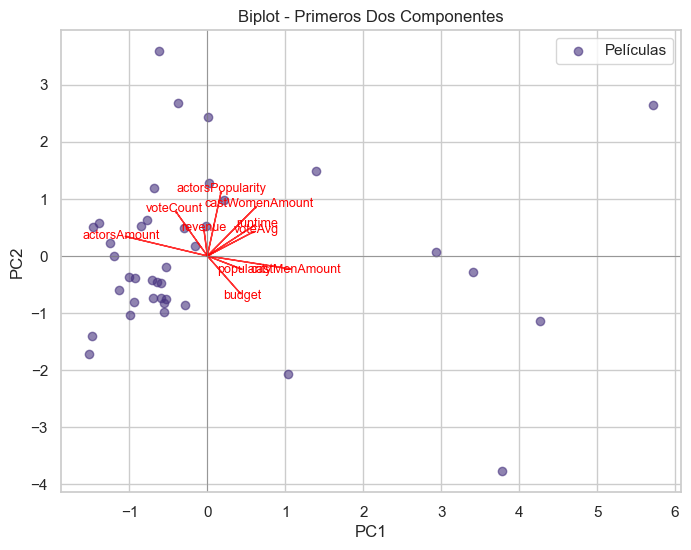

In [21]:
# BIPLOT EN LOS DOS PRIMEROS COMPONENTES

# Ajustar PCA a 2 componentes
pca_2 = PCA(n_components=2)
pca_2.fit(df_scaled)
pca_2_data = pca_2.transform(df_scaled)
loadings_2 = pca_2.components_.T  # (num_variables x 2)

plt.figure(figsize=(8,6))

# Puntos: las películas en PC1 vs. PC2
plt.scatter(pca_2_data[:, 0], pca_2_data[:, 1], alpha=0.6, label="Películas")

# Flechas: las variables
feature_names = df_scaled.columns
for i, var in enumerate(feature_names):
    x = loadings_2[i, 0]
    y = loadings_2[i, 1]
    plt.arrow(0, 0, x*2, y*2, color='red', alpha=0.8, head_width=0.02, length_includes_head=True)
    plt.text(x*2.1, y*2.1, var, color='red', ha='center', va='center', fontsize=9)

plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Biplot - Primeros Dos Componentes")
plt.grid(True)
plt.legend()
plt.show()

## Conclusiones del PCA

**1. Prueba de Bartlett y KMO**  
- El valor p de la prueba de **Bartlett** fue 1.465e-15 (< 0.05), lo que confirma que sí hay correlación suficiente entre variables para justificar el PCA.  
- El **Índice KMO** fue 0.51 (≈ 0.51), por debajo de 0.60. Esto sugiere que, si bien puede realizarse el PCA, las variables no tienen una adecuación óptima para un análisis factorial; podría indicar que ciertas variables podrían ser removidas o que se necesitaría una transformación/adición de otras variables para obtener un índice KMO más alto.

**2. Varianza Explicada**  
- Se calcularon 10 componentes (igual al número de variables numéricas).  
- El primer componente (PC1) explica cerca del 28.43% de la varianza; los primeros 5 componentes alcanzan aproximadamente el 79.2% de la varianza acumulada.  
- Si se busca un umbral de ~70-80% de la varianza explicada, retener 5 componentes puede ser razonable (PC1 a PC5).

**3. Scree Plot y Selección de Componentes**  
- El Scree Plot (Gráfico de Codo) muestra cómo la varianza acumulada se aproxima al 80% en torno al componente 5.  
- Por lo tanto, podría ser adecuado retener **4 o 5** componentes, dependiendo de cuánta varianza se quiera conservar.

**4. Interpretación de los Componentes**  
- A partir de la matriz de **loadings**, puede verse qué variables influyen en cada componente.  
  - Por ejemplo, variables con altas cargas en PC1 podrían representar un eje asociado a ciertos rasgos (como ‘popularity’ o ‘runtime’), mientras que PC2 podría asociarse más con ‘actorsPopularity’ o ‘voteCount’.  
- Este análisis ayuda a **entender** la naturaleza de cada componente, permitiendo explicar “en qué sentido” se reduce la dimensionalidad.

**5. Uso Posterior y Recomendaciones**  
- Con ~79.2% de varianza explicada en los primeros 5 componentes, se reduce significativamente la dimensionalidad al trabajar solo con esos 5 ejes en análisis posteriores (clustering, visualizaciones, predicción, etc.).  
- Dado que el KMO no es tan alto (0.51), convendría:
  1. **Revisar** si hay variables redundantes o poco correlacionadas, para eliminarlas y recalcular el PCA.  
  2. **Explorar** transformaciones adicionales de variables (por ejemplo, logaritmos si hay sesgos muy altos, discretizaciones, etc.).  

**Conclusión Principal**  
- El PCA realizado logra captar cerca de un 80% de la varianza en 5 componentes, lo que es útil para simplificar análisis posteriores.  
- No obstante, el KMO sugiere que podría afinarse la selección de variables o considerar otras transformaciones para mejorar la adecuación del PCA.  